## Learning objectives

By the end of this notebook you should be able to:

* Add polynomial features using both statsmodels and scikit-learn to capture nonlinearity.

* Compare model performance across different polynomial degrees.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

sns.set_theme(style="whitegrid", font_scale=1.2)

## Polynomial transformations in statesmodel

Let's use the same dataset


In [3]:
# Read data
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')

train = pd.merge(trainf, trainp)
test = pd.merge(testf, testp)

# Create age feature using the most recent model year in the training data
reference_year = train["year"].max()
train["age"] = reference_year - train["year"]
test["age"] = reference_year - test["year"]

train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price,age
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980,0
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980,1
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850,0
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998,3
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990,5


In [4]:
train_updated = train[train.transmission != 'Other']

So far we assumed linear relationships. If the relationship between `price` and `mileage` is curved, polynomial terms can help.

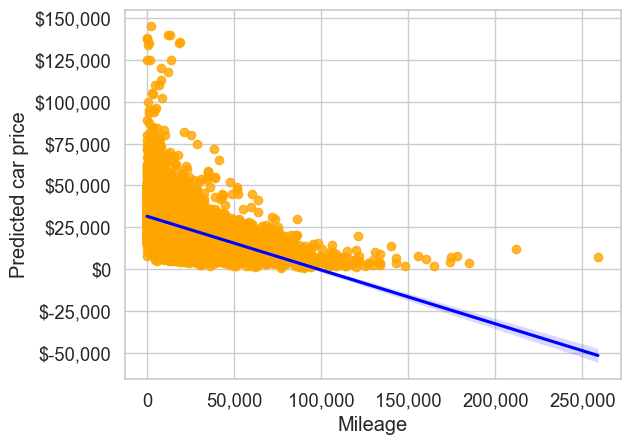

In [5]:
# Relationship between price and mileage
ax = sns.regplot(x=train_updated.mileage, y=train_updated.price, color='orange', line_kws={'color': 'blue'})
plt.xlabel('Mileage')
plt.ylabel('Predicted car price')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.xaxis.set_major_formatter('{x:,.0f}')


In [ ]:
# R-squared of the model with just mileage
model_sm_mileage = smf.ols('price ~ mileage', data=train_updated).fit()
model_sm_mileage.rsquared


0.22928048993376182

#### Quadratic transformation

Add a squared term for `mileage` using the `I()` operator to keep it as a separate predictor.


In [ ]:
model_sm_quad = smf.ols('price ~ mileage + I(mileage**2)', data=train_updated).fit()
model_sm_quad.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     920.6
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:57:58   Log-Likelihood:                -54382.
No. Observations:                4959   AIC:                         1.088e+05
Df Residuals:                    4956   BIC:                         1.088e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         3.44e+04    332.710    103.382      0.000    3.37e+04     3.5e+04
mileage            -0.5662      0.017    -33.940      0.000      -0.599      -0.534
I(mileage ** 2)  2.629e-06   1.56e-07     16.813      0.000    2.32e-06    2.94e-06
==============================================================================
Omnibus:                     2362.973   Durbin-Watson:                   0.325
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22427.952
Skew:                           2.052   Prob(JB):                         0.00
Kurtosis:                      12.576   Cond. No.                     4.81e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.81e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

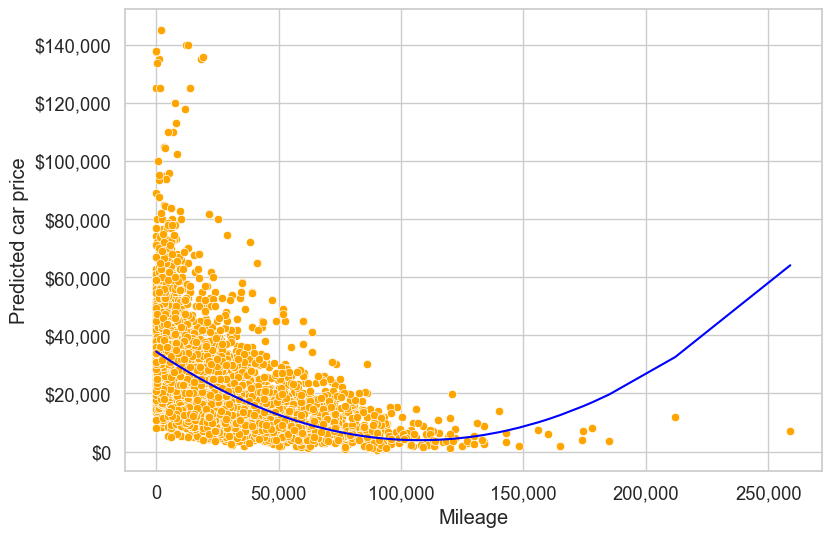

In [ ]:
# Visualize the quadratic fit
pred_price = model_sm_quad.predict(train_updated)
ax = sns.scatterplot(x='mileage', y='price', data=train_updated, color='orange')
sns.lineplot(x=train_updated.mileage, y=pred_price, color='blue')
plt.xlabel('Mileage')
plt.ylabel('Predicted car price')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.xaxis.set_major_formatter('{x:,.0f}')


#### Cubic transformation

Add a cubic term for additional flexibility.


In [ ]:
model_sm_cubic = smf.ols('price ~ mileage + I(mileage**2) + I(mileage**3)', data=train_updated).fit()
model_sm_cubic.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     652.3
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:58:10   Log-Likelihood:                -54340.
No. Observations:                4959   AIC:                         1.087e+05
Df Residuals:                    4955   BIC:                         1.087e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3.598e+04    371.925     96.728      0.000    3.52e+04    3.67e+04
mileage            -0.7742      0.028    -27.634      0.000      -0.829      -0.719
I(mileage ** 2)  6.875e-06   4.87e-07     14.119      0.000    5.92e-06    7.83e-06
I(mileage ** 3) -1.823e-11   1.98e-12     -9.199      0.000   -2.21e-11   -1.43e-11
==============================================================================
Omnibus:                     2380.789   Durbin-Watson:                   0.321
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23039.334
Skew:                           2.065   Prob(JB):                         0.00
Kurtosis:                      12.719   Cond. No.                     7.73e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.73e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

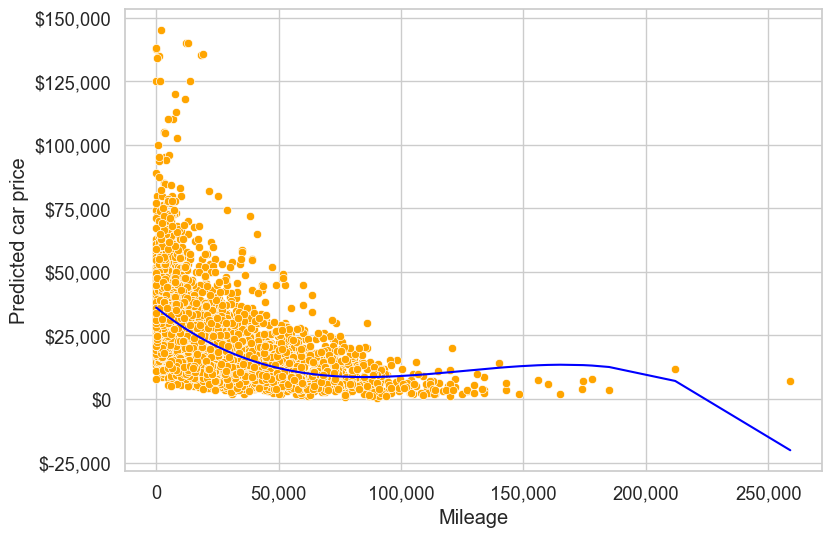

In [ ]:
# Visualize the cubic fit
pred_price = model_sm_cubic.predict(train_updated)
ax = sns.scatterplot(x='mileage', y='price', data=train_updated, color='orange')
sns.lineplot(x=train_updated.mileage, y=pred_price, color='blue')
plt.xlabel('Mileage')
plt.ylabel('Predicted car price')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.xaxis.set_major_formatter('{x:,.0f}')


#### Putting interaction and transformation together

Combine the interaction term with a quadratic mileage term.


In [ ]:
model_sm_full = smf.ols(
    formula='price ~ age*engineSize + mileage + mpg + I(mileage**2)',
    data=train_updated,
).fit()

model_sm_full.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     1947.
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        10:58:23   Log-Likelihood:                -52162.
No. Observations:                4959   AIC:                         1.043e+05
Df Residuals:                    4952   BIC:                         1.044e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3853.3738    779.161      4.946      0.000    2325.873    5380.875
age               755.7419    133.791      5.649      0.000     493.453    1018.031
engineSize       1.565e+04    241.430     64.811      0.000    1.52e+04    1.61e+04
age:engineSize  -1008.6993     48.196    -20.929      0.000   -1103.184    -914.215
mileage            -0.3548      0.014    -25.973      0.000      -0.382      -0.328
mpg               -54.7450      8.896     -6.154      0.000     -72.185     -37.305
I(mileage ** 2)  1.926e-06   1.04e-07     18.536      0.000    1.72e-06    2.13e-06
==============================================================================
Omnibus:                     2355.448   Durbin-Watson:                   0.562
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38317.406
Skew:                           1.857   Prob(JB):                         0.00
Kurtosis:                      16.101   Cond. No.                     1.83e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.83e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
# RMSE on test data
pred_price = model_sm_full.predict(test)
np.sqrt(((test.price - pred_price) ** 2).mean())


9074.49407060908

## Polynomial Features in scikit-learn

### Simulate the dataset

We simulate two predictors (`x1`, `x2`) from uniform distributions and generate the target `y` from a nonlinear function with added noise. This setup lets us compare linear vs polynomial models on data with known nonlinearity.

In [2]:
import numpy as np
import pandas as pd

# Set a random seed for reproducibility
np.random.seed(42)

# Number of samples
N = 5000

# Generate features from uniform distributions
x1 = np.random.uniform(-5, 5, N)
x2 = np.random.uniform(-5, 5, N)

# Define a nonlinear relationship with Gaussian noise
y = 1.5 * (x1 ** 2) + 0.5 * (x2 ** 3) + np.random.normal(loc=3, scale=3, size=N)

# Create a pandas DataFrame
df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

# Save to CSV (optional)
df.to_csv('nonlinear_dataset.csv', index=False)

df.head(10)  # Display the first 10 rows


,x1,x2,y
0,-1.254599,-1.063645,0.295770
1,4.507143,-0.265643,30.086577
2,2.319939,3.545474,34.523622
3,0.986585,-1.599956,-1.109427
4,-3.439814,3.696497,49.341010
5,-3.440055,-4.118656,-14.395442
6,-4.419164,2.767984,43.154083
7,3.661761,3.475476,43.267654
8,1.011150,-3.181823,-9.254211
9,2.080726,-0.696535,11.674644


### Target-Feature Split

In [ ]:
# Create feature matrix and target vector
X = df[['x1', 'x2']].values
y = df['y'].values

### Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (4000, 2)
Testing set shape: (1000, 2)



## Baseline Model (original Features)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

# Fit a baseline linear regression model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predict on train and test splits
y_pred_baseline = baseline_model.predict(X_test)
y_train_pred_baseline = baseline_model.predict(X_train)

# Evaluate on test and training sets
rmse_baseline = root_mean_squared_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

rmse_train_baseline = root_mean_squared_error(y_train, y_train_pred_baseline)
r2_train_baseline = r2_score(y_train, y_train_pred_baseline)

print()
print("Baseline Model Performance:")
print("Training Set:")
print("RMSE:", rmse_train_baseline)
print("R2:", r2_train_baseline)
print()
print("Testing Set:")
print("RMSE:", rmse_baseline)
print("R2:", r2_baseline)



Baseline Model Performance:
Training Set:
RMSE: 14.793577191492002
R2: 0.6720857612554578

Testing Set:
RMSE: 14.766591570386126
R2: 0.6745129537467693


## Transform Features with PolynomialFeatures (`degree = 2`)

In [8]:
from sklearn.preprocessing import PolynomialFeatures

# Create PolynomialFeatures object with degree=2 (includes interaction terms)
poly_2 = PolynomialFeatures(degree=2, include_bias=False)

# Transform the training and testing features
X_train_poly_2 = poly_2.fit_transform(X_train)
X_test_poly_2 = poly_2.transform(X_test)

# Display the transformed feature names
print()
print("Transformed Feature Names:")
print(poly_2.get_feature_names_out())



Transformed Feature Names:
['x0' 'x1' 'x0^2' 'x0 x1' 'x1^2']


### Linear Model with transformed Features (`degree = 2`)

In [10]:
# Fit a linear regression model on degree-2 polynomial features
poly_2_model = LinearRegression()
poly_2_model.fit(X_train_poly_2, y_train)

# Predict on train and test splits
y_pred_poly_2 = poly_2_model.predict(X_test_poly_2)
y_train_pred_poly_2 = poly_2_model.predict(X_train_poly_2)

# Evaluate on test and training sets
rmse_poly_2 = root_mean_squared_error(y_test, y_pred_poly_2)
r2_poly_2 = r2_score(y_test, y_pred_poly_2)

rmse_train_poly_2 = root_mean_squared_error(y_train, y_train_pred_poly_2)
r2_train_poly_2 = r2_score(y_train, y_train_pred_poly_2)

print()
print("Polynomial Model Performance:")
print("Training Set:")
print("RMSE:", rmse_train_poly_2)
print("R2:", r2_train_poly_2)
print()
print("Testing Set:")
print("RMSE:", rmse_poly_2)
print("R2:", r2_poly_2)



Polynomial Model Performance:
Training Set:
RMSE: 9.762877774623902
R2: 0.8571863972474734

Testing Set:
RMSE: 9.486906471561829
R2: 0.8656547173222298


### Transform features with PolynomialFeatures (`degree = 3`)

In [11]:
# Create PolynomialFeatures object with degree=3
poly_3 = PolynomialFeatures(degree=3, include_bias=False)

# Transform the training and testing features
X_train_poly_3 = poly_3.fit_transform(X_train)
X_test_poly_3 = poly_3.transform(X_test)

# Display the transformed feature names
print()
print("Transformed Feature Names:")
print(poly_3.get_feature_names_out())



Transformed Feature Names:
['x0' 'x1' 'x0^2' 'x0 x1' 'x1^2' 'x0^3' 'x0^2 x1' 'x0 x1^2' 'x1^3']


### Linear Model with transformed Features (`degree = 3`)

In [12]:
# Fit a linear regression model on degree-3 polynomial features
poly_3_model = LinearRegression()
poly_3_model.fit(X_train_poly_3, y_train)

# Predict on train and test splits
y_pred_poly_3 = poly_3_model.predict(X_test_poly_3)
y_pred_train_poly_3 = poly_3_model.predict(X_train_poly_3)

# Evaluate on test and training sets
rmse_poly_3 = root_mean_squared_error(y_test, y_pred_poly_3)
r2_poly_3 = r2_score(y_test, y_pred_poly_3)

rmse_poly_3_train = root_mean_squared_error(y_train, y_pred_train_poly_3)
r2_poly_3_train = r2_score(y_train, y_pred_train_poly_3)

print()
print("Polynomial Model Performance:")
print("Training Set:")
print("RMSE:", rmse_poly_3_train)
print("R2:", r2_poly_3_train)
print()
print("Testing Set:")
print("RMSE:", rmse_poly_3)
print("R2:", r2_poly_3)



Polynomial Model Performance:
Training Set:
RMSE: 2.940512343419126
R2: 0.9870443297925774

Testing Set:
RMSE: 3.0056638608303694
R2: 0.9865149052434146


### `degree = 4`


In [15]:
# use polynominal degree of 4 to see if it improves the model
poly_4 = PolynomialFeatures(degree=4, include_bias=False)

# Transform the training and testing features
X_train_poly_4 = poly_4.fit_transform(X_train)
X_test_poly_4 = poly_4.transform(X_test)

# Create a linear regression model for the polynomial features
poly_4_model = LinearRegression()

# Train the model on the transformed features
poly_4_model.fit(X_train_poly_4, y_train)

# Make predictions on the test set
y_pred_poly_4 = poly_4_model.predict(X_test_poly_4)

# Make predictions on the training set
y_pred_train_poly_4 = poly_4_model.predict(X_train_poly_4)

# Evaluate the polynomial model
rmse_poly_4 = root_mean_squared_error(y_test, y_pred_poly_4)
r2_poly_4 = r2_score(y_test, y_pred_poly_4)

# Evaluate the polynomial model on the training set
rmse_poly_4_train = root_mean_squared_error(y_train, y_pred_train_poly_4)
r2_poly_4_train = r2_score(y_train, y_pred_train_poly_4)

print()
print("Polynomial Model Performance:")
print("Training Set:")
print("RMSE:", rmse_poly_4_train)
print("R2:", r2_poly_4_train)
print()
print("Testing Set:")
print("RMSE:", rmse_poly_4)
print("R2:", r2_poly_4)



Polynomial Model Performance:
Training Set:
RMSE: 2.9383287792953574
R2: 0.98706356387817

Testing Set:
RMSE: 2.9985680032522617
R2: 0.9865785020821749


In [16]:
# get the feature names for the polynomial degree 4 model
print("\nNumber of Features:", len(poly_4.get_feature_names_out()))
print("\nTransformed Feature Names:")
print(poly_4.get_feature_names_out())



Number of Features: 14

Transformed Feature Names:
['x0' 'x1' 'x0^2' 'x0 x1' 'x1^2' 'x0^3' 'x0^2 x1' 'x0 x1^2' 'x1^3' 'x0^4'
 'x0^3 x1' 'x0^2 x1^2' 'x0 x1^3' 'x1^4']


### Putting all together

In [18]:
# Summarize model performance side by side
models = ['Baseline', 'Polynomial Degree 2', 'Polynomial Degree 3', 'Polynomial Degree 4']
features = [
    X.shape[1],
    len(poly_2.get_feature_names_out()),
    len(poly_3.get_feature_names_out()),
    len(poly_4.get_feature_names_out()),
]
training_rmse = [rmse_train_baseline, rmse_train_poly_2, rmse_poly_3_train, rmse_poly_4_train]
testing_rmse = [rmse_baseline, rmse_poly_2, rmse_poly_3, rmse_poly_4]
training_r2 = [r2_train_baseline, r2_train_poly_2, r2_poly_3_train, r2_poly_4_train]
testing_r2 = [r2_baseline, r2_poly_2, r2_poly_3, r2_poly_4]

model_comparison = pd.DataFrame(
    {
        'Model': models,
        'Features': features,
        'Training RMSE': training_rmse,
        'Testing RMSE': testing_rmse,
        'Training R2': training_r2,
        'Testing R2': testing_r2,
    }
)

model_comparison


,Model,Features,Training MSE,Testing MSE,Training R2,Testing R2
0,Baseline,2,14.793577,14.766592,0.672086,0.674513
1,Polynomial Degree 2,5,9.762878,9.486906,0.857186,0.865655
2,Polynomial Degree 3,9,2.940512,3.005664,0.987044,0.986515
3,Polynomial Degree 4,14,2.938329,2.998568,0.987064,0.986579


when increase degree to 4, we can see the performance 

### Key takeaway:

In `scikit-learn`, the built-in `PolynomialFeatures` transformer is somewhat “all or nothing”: by default, it generates **all** polynomial terms (including interactions) up to a certain degree. You can toggle:

* `interaction_only=True` to generate only cross-terms
* `include_bias=False` to exclude the constant (bias) term,
* `degree` to control how high the polynomial powers go.

However, if you want **fine-grained control** over exactly which terms get generated (for example, only certain interaction terms, or only a subset of polynomial terms), you will need to create those features manually or write a custom transformer (skipped for beginner level)

Use `interaction_only` for Cross Terms Only

If your goal is only to capture interaction terms (i.e., $ x_1 \times x_2 $, but no squares, cubes, etc.), you can set:

In [17]:
poly_int = PolynomialFeatures(degree=6, 
                             interaction_only=True, 
                             include_bias=False)

X_transformed = poly_int.fit_transform(X)

print("\nTransformed Feature Names:")
print(poly_int.get_feature_names_out())



Transformed Feature Names:
['x0' 'x1' 'x0 x1']


If you want to be very selective—say, just add $x_1^2$ and $ x_1 \times x_2 $ but not  $x_2^2$ —the simplest approach is to create columns by hand. For example:

In [30]:
import numpy as np
import pandas as pd

# Set a random seed for reproducibility
np.random.seed(42)

# Number of samples
N = 5000

# Generate features from uniform distributions
x1 = np.random.uniform(-5, 5, N)
x2 = np.random.uniform(-5, 5, N)

# Define a nonlinear relationship with Gaussian noise
y = 1.5 * (x1 ** 2) + 0.5 * (x2 ** 3) + np.random.normal(loc=3, scale=3, size=N)

# Create a pandas DataFrame
df = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})

# Save to CSV (optional)
df.to_csv('nonlinear_dataset.csv', index=False)

df.head(10)  # Display the first 10 rows



Transformed Feature Names:
['x1', 'x2', 'x1^2', 'x1*x2']


array([[ -1.25459881,  -1.0636448 ,   1.57401818,   1.3344475 ],
       [  4.50714306,  -0.26564341,  20.3143386 ,  -1.19729284],
       [  2.31993942,   3.54547393,   5.3821189 ,   8.22528473],
       [  0.98658484,  -1.59995614,   0.97334965,  -1.57849247],
       [ -3.4398136 ,   3.69649685,  11.83231757, -12.71526011]])

When using `PolynomialFeatures` (or any other scikit-learn transformer), the fitting step is always done on the training data—not on the test data. This is a fundamental principle of machine learning pipelines: we do not use the test set for any part of model training (including feature encoding, feature generation, scaling, etc.). 